# Analyse and Visualize Model 

In [1]:
# Imports

from argparse import ArgumentParser, RawTextHelpFormatter
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import json
import cv2 as cv
import open3d as o3d 
from gradslam.structures.rgbdimages import RGBDImages
from end2endslam.dataloader.tum import TUM
from end2endslam.dataloader.nyu import NYU
from gradslam.slam.pointfusion import PointFusion
from gradslam.structures.pointclouds import Pointclouds
from end2endslam.scsfmwrapper import SCSfmWrapper
from losses.unified_loss import pred_loss_unified
from losses.gt_loss import compute_errors 
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import matplotlib as mpl
import matplotlib.cm as cm
import imageio
from end2endslam.pointfusion_scsfm_utils import compute_scaling_coef, slam_step
import matplotlib.pyplot as plt
from end2endslam.losses.loss_utils.inverse_warp import inverse_warp2
from end2endslam.losses.loss_utils.scsfm_loss import compute_ssim_loss, mean_on_mask
import csv
import pandas as pd

## NYU and TUM sample Images

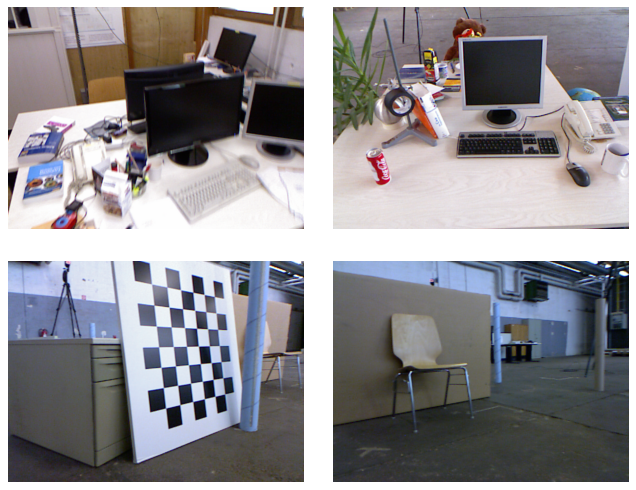

In [2]:
tum_dir = "../presentation/tum_images/"
tum1 = plt.imread(os.path.join(tum_dir, "1305031468.795796.png"))
tum2 = plt.imread(os.path.join(tum_dir, "1311867172.926322.png"))
tum3 = plt.imread(os.path.join(tum_dir, "1311878195.174269.png"))
tum4 = plt.imread(os.path.join(tum_dir, "1311878205.741858.png"))

figure0a = plt.figure(figsize=(10, 8), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax = plt.subplot(2,2,1)
plt.axis('off')
ax.imshow(tum1)
ax = plt.subplot(2,2,2)
plt.axis('off')
ax.imshow(tum2)
ax = plt.subplot(2,2,3)
plt.axis('off')
ax.imshow(tum3)
ax = plt.subplot(2,2,4)
plt.axis('off')
ax.imshow(tum4)
figure0a.savefig("../presentation/tum_images.pdf", bbox_inches='tight')
figure0a.savefig("../presentation/tum_images.png", bbox_inches='tight')


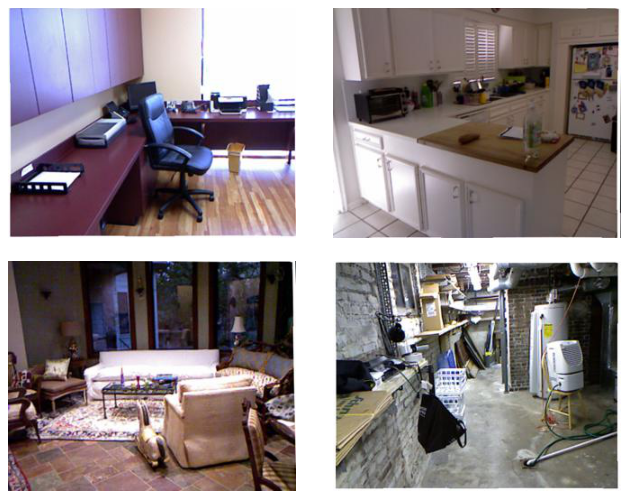

In [3]:
nyu_dir = "../presentation/nyu_images/"
nyu1 = plt.imread(os.path.join(nyu_dir, "000001_1.jpg"))
nyu2 = plt.imread(os.path.join(nyu_dir, "000005_1.jpg"))
nyu3 = plt.imread(os.path.join(nyu_dir, "000006_1.jpg"))
nyu4 = plt.imread(os.path.join(nyu_dir, "000041.jpg"))

figure0b = plt.figure(figsize=(10, 8.), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax = plt.subplot(2,2,1)
plt.axis('off')
ax.imshow(nyu1)
ax = plt.subplot(2,2,2)
plt.axis('off')
ax.imshow(nyu2)
ax = plt.subplot(2,2,3)
plt.axis('off')
ax.imshow(nyu3)
ax = plt.subplot(2,2,4)
plt.axis('off')
ax.imshow(nyu4)
figure0b.savefig("../presentation/nyu_images.pdf", bbox_inches='tight')
figure0b.savefig("../presentation/nyu_images.png", bbox_inches='tight')

## Losses Plot

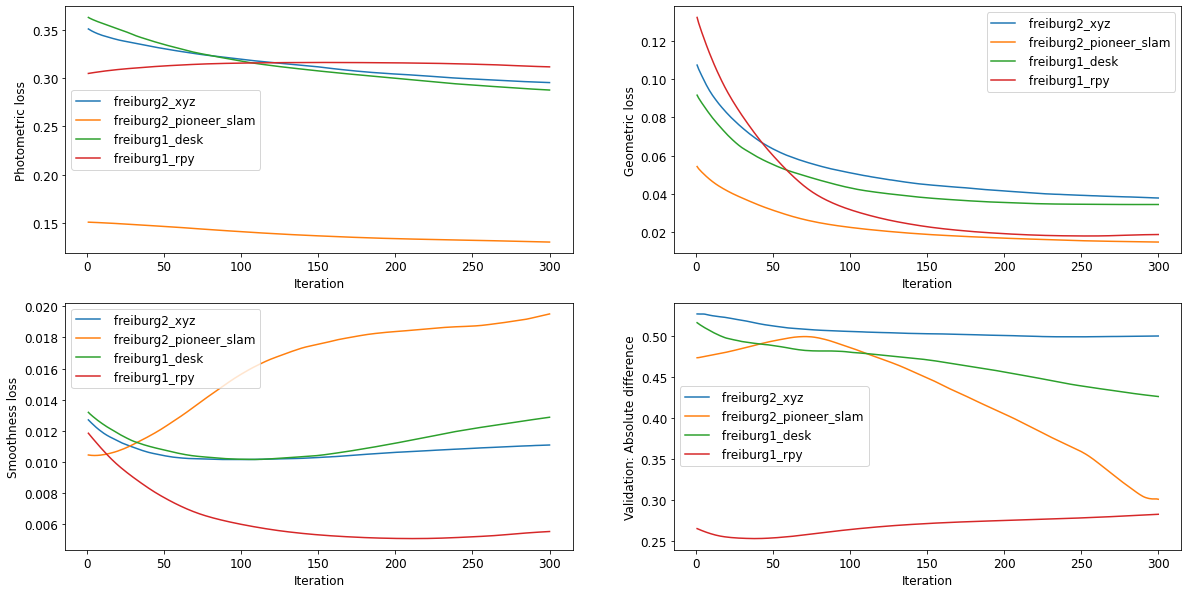

In [15]:
# get args
class Bunch(object): # in order to call args.seed 
    def __init__(self, adict):
        self.__dict__.update(adict)

args_dir_list = []
data_list=[]
args_dir_list.append("../final_logs/xyzs_000_previous_scale1_dil100/")
args_dir_list.append("../final_logs/slams_010_previous_scale1_dil9/")
args_dir_list.append("../final_logs/desks_010_previous_scale1_dil6")
args_dir_list.append("../final_logs/rpys_010_previous_scale1_dil6/")

for args_dir in args_dir_list:
    summary_path = os.path.join(args_dir, "training_summary.csv")
    data = pd.read_csv(summary_path)
    with open(os.path.join(args_dir, "args.txt")) as f:
        args = json.load(f)
        args = Bunch(args)
    data_list.append((args, data))
        
figure1 = plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 12})

# Photometric loss
ax = plt.subplot(2,2,1) 
ax.set_xlabel("Iteration")
ax.set_ylabel("Photometric loss")
for args, data in data_list:
    iteration = data["iteration"].values
    photo = data["photo"].values
    line, = ax.plot(iteration, photo)
    line.set_label(args.sequences.replace('rgbd_dataset_', ' '))
ax.legend()

# Geometric loss
ax = plt.subplot(2,2,2) 
ax.set_xlabel("Iteration")
ax.set_ylabel("Geometric loss")
for args, data in data_list:
    iteration = data["iteration"].values
    photo = data["geom"].values
    line, = ax.plot(iteration, photo)
    line.set_label(args.sequences.replace('rgbd_dataset_', ' '))
ax.legend()

# Smoothness loss
ax = plt.subplot(2,2,3) 
ax.set_xlabel("Iteration")
ax.set_ylabel("Smoothness loss")
for args, data in data_list:
    iteration = data["iteration"].values
    photo = data["smooth"].values
    line, = ax.plot(iteration, photo)
    line.set_label(args.sequences.replace('rgbd_dataset_', ' '))
ax.legend()

# Validation loss
ax = plt.subplot(2,2,4) 
ax.set_xlabel("Iteration")
ax.set_ylabel("Validation: Absolute difference")
for args, data in data_list:
    iteration = data["iteration"].values
    photo = data["val_abs_diff"].values
    line, = ax.plot(iteration, photo)
    line.set_label(args.sequences.replace('rgbd_dataset_', ' '))
ax.legend()

figure1.savefig("../presentation/losses1.pdf", bbox_inches='tight')
figure1.savefig("../presentation/losses1.png", bbox_inches='tight')

## Loss weights ablation

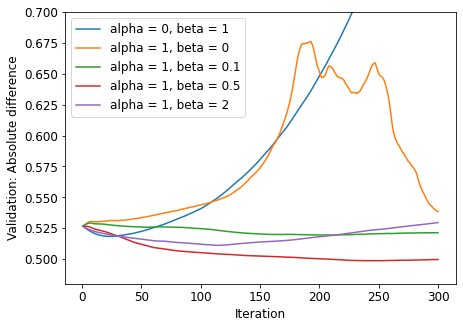

In [14]:
# get args
class Bunch(object): # in order to call args.seed 
    def __init__(self, adict):
        self.__dict__.update(adict)

args_dir_list = []
data_list=[]
args_dir_list.append("../final_logs/xyzs_902_previous_scale1_dil100/")
args_dir_list.append("../final_logs/xyzs_901_previous_scale1_dil100/")
args_dir_list.append("../final_logs/xyzs_904_previous_scale1_dil100/")
args_dir_list.append("../final_logs/xyzs_000_previous_scale1_dil100/")
args_dir_list.append("../final_logs/xyzs_903_previous_scale1_dil100/")


for args_dir in args_dir_list:
    summary_path = os.path.join(args_dir, "training_summary.csv")
    data = pd.read_csv(summary_path)
    with open(os.path.join(args_dir, "args.txt")) as f:
        args = json.load(f)
        args = Bunch(args)
    data_list.append((args, data))
        
figure1 = plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 12})

# Validation loss
ax = plt.subplot(1,1,1) 
ax.set_xlabel("Iteration")
ax.set_ylabel("Validation: Absolute difference")
for args, data in data_list:
    iteration = data["iteration"].values
    photo = data["val_abs_diff"].values
    line, = ax.plot(iteration, photo)
    if "000" in args.model_name:
        line.set_label('alpha = 1, beta = 0.5')
    elif "901" in args.model_name:
        line.set_label('alpha = 1, beta = 0')
    elif "902" in args.model_name:
        line.set_label('alpha = 0, beta = 1')
    elif "903" in args.model_name:
        line.set_label('alpha = 1, beta = 2')
    elif "904" in args.model_name:
        line.set_label('alpha = 1, beta = 0.1')
plt.ylim([0.48, 0.7])
ax.legend()

figure1.savefig("../presentation/loss_weights.pdf", bbox_inches='tight')
figure1.savefig("../presentation/loss_weights.png", bbox_inches='tight')

## Show images for XYZ and SLAM

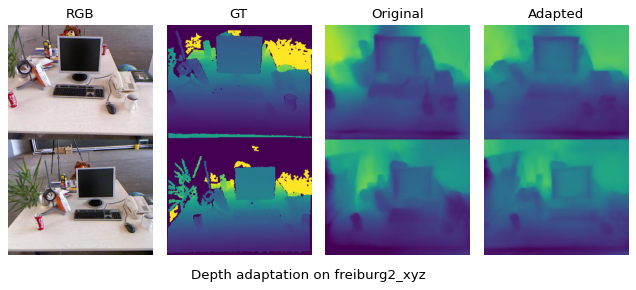

In [4]:
# XYZ 

xyz_dir = "../final_logs/xyzs_000_previous_scale1_dil100/"
rgb = plt.imread(os.path.join(xyz_dir, "0_0_color.jpg"))
d_gt = plt.imread(os.path.join(xyz_dir, "0_0_gt.jpg"))
d_0 = plt.imread(os.path.join(xyz_dir, "0_0_pred.jpg"))
d_270 = plt.imread(os.path.join(xyz_dir, "270_0_pred.jpg"))


figure2 = plt.figure(figsize=(10, 5), dpi=80)
figure2.suptitle('Depth adaptation on freiburg2_xyz', y=0.18)
plt.subplots_adjust(wspace=0.1)
ax1 = plt.subplot(1,4,1)
plt.axis('off')
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1 = plt.subplot(1,4,2)
plt.axis('off')
ax1.imshow(d_gt)
ax1.set_title('GT')
ax1 = plt.subplot(1,4,3)
plt.axis('off')
ax1.imshow(d_0)
ax1.set_title('Original')
ax1 = plt.subplot(1,4,4)
plt.axis('off')
ax1.imshow(d_270)
ax1.set_title('Adapted')

figure2.savefig("../presentation/depth_xyz.pdf", bbox_inches='tight')
figure2.savefig("../presentation/depth_xyz.png", bbox_inches='tight')

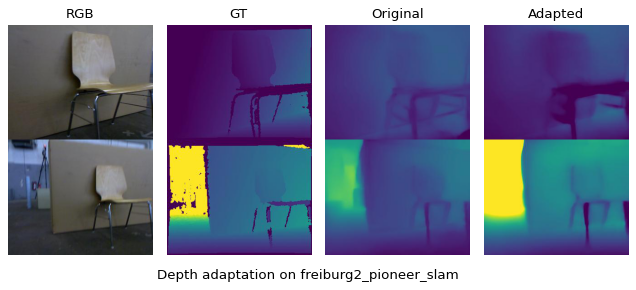

In [5]:
# SLAM 

slam_dir = "../final_logs/slams_010_previous_scale1_dil9/"
rgb = plt.imread(os.path.join(slam_dir, "0_0_color.jpg"))
d_gt = plt.imread(os.path.join(slam_dir, "0_0_gt.jpg"))
d_0 = plt.imread(os.path.join(slam_dir, "0_0_pred.jpg"))
d_270 = plt.imread(os.path.join(slam_dir, "270_0_pred.jpg"))


figure3 = plt.figure(figsize=(10, 5), dpi=80)
figure3.suptitle('Depth adaptation on freiburg2_pioneer_slam', y=0.18)
plt.subplots_adjust(wspace=0.1)
ax1 = plt.subplot(1,4,1)
plt.axis('off')
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1 = plt.subplot(1,4,2)
plt.axis('off')
ax1.imshow(d_gt)
ax1.set_title('GT')
ax1 = plt.subplot(1,4,3)
plt.axis('off')
ax1.imshow(d_0)
ax1.set_title('Original')
ax1 = plt.subplot(1,4,4)
plt.axis('off')
ax1.imshow(d_270)
ax1.set_title('Adapted')

figure3.savefig("../presentation/depth_slam.pdf", bbox_inches='tight')
figure3.savefig("../presentation/depth_slam.png", bbox_inches='tight')

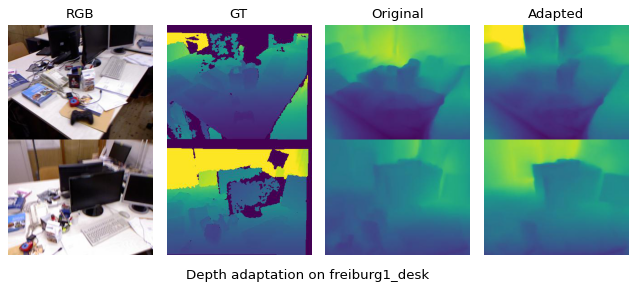

In [6]:
# Desk

desk_dir = "../final_logs/desks_010_previous_scale1_dil6/"
rgb = plt.imread(os.path.join(desk_dir, "0_0_color.jpg"))
d_gt = plt.imread(os.path.join(desk_dir, "0_0_gt.jpg"))
d_0 = plt.imread(os.path.join(desk_dir, "0_0_pred.jpg"))
d_270 = plt.imread(os.path.join(desk_dir, "270_0_pred.jpg"))


figure4 = plt.figure(figsize=(10, 5), dpi=80)
figure4.suptitle('Depth adaptation on freiburg1_desk', y=0.18)
plt.subplots_adjust(wspace=0.1)
ax1 = plt.subplot(1,4,1)
plt.axis('off')
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1 = plt.subplot(1,4,2)
plt.axis('off')
ax1.imshow(d_gt)
ax1.set_title('GT')
ax1 = plt.subplot(1,4,3)
plt.axis('off')
ax1.imshow(d_0)
ax1.set_title('Original')
ax1 = plt.subplot(1,4,4)
plt.axis('off')
ax1.imshow(d_270)
ax1.set_title('Adapted')

figure4.savefig("../presentation/depth_desk.pdf", bbox_inches='tight')
figure4.savefig("../presentation/depth_desk.png", bbox_inches='tight')

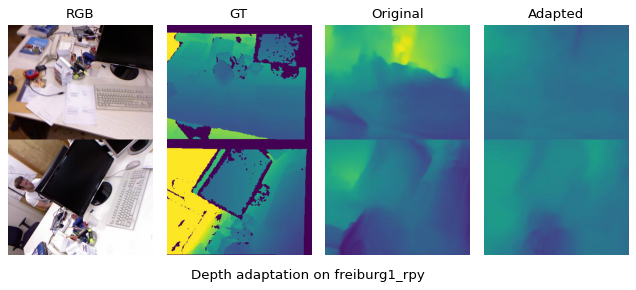

In [7]:
# RPY

desk_dir = "../final_logs/rpys_010_previous_scale1_dil6//"
rgb = plt.imread(os.path.join(desk_dir, "0_0_color.jpg"))
d_gt = plt.imread(os.path.join(desk_dir, "0_0_gt.jpg"))
d_0 = plt.imread(os.path.join(desk_dir, "0_0_pred.jpg"))
d_270 = plt.imread(os.path.join(desk_dir, "270_0_pred.jpg"))


figure5 = plt.figure(figsize=(10, 5), dpi=80)
figure5.suptitle('Depth adaptation on freiburg1_rpy', y=0.18)
plt.subplots_adjust(wspace=0.1)
ax1 = plt.subplot(1,4,1)
plt.axis('off')
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1 = plt.subplot(1,4,2)
plt.axis('off')
ax1.imshow(d_gt)
ax1.set_title('GT')
ax1 = plt.subplot(1,4,3)
plt.axis('off')
ax1.imshow(d_0)
ax1.set_title('Original')
ax1 = plt.subplot(1,4,4)
plt.axis('off')
ax1.imshow(d_270)
ax1.set_title('Adapted')

figure5.savefig("../presentation/depth_rpy.pdf", bbox_inches='tight')
figure5.savefig("../presentation/depth_rpy.png", bbox_inches='tight')

## Environment comparison

In [10]:
# get args
class Bunch(object): # in order to call args.seed 
    def __init__(self, adict):
        self.__dict__.update(adict)

data_list=[]
base_dir = "../final_logs/"
rel_dir_list = os.listdir(base_dir)
args_dir_list = [os.path.join(base_dir, sub_dir) for sub_dir in rel_dir_list]

for args_dir in args_dir_list:
    summary_path = os.path.join(args_dir, "training_summary.csv")
    data = pd.read_csv(summary_path)
    with open(os.path.join(args_dir, "args.txt")) as f:
        args = json.load(f)
        args = Bunch(args)
    data_list.append((args, data))

#df = pd.DataFrame(columns=['Sequence','Dilation','Avg. Translation','Avg. Rotation','Relative Validation Improvement'])
df = pd.DataFrame()
for args, data in data_list:
    #print(args.__dict__)
    #print(data)
    sequence = args.sequences.replace('rgbd_dataset_', ' ')
    dilation = args.seq_dilation 
    transl_diff = data["mag_gt_transl"].values[0]
    rot_diff = data["mag_gt_rot"].values[0]
    epoch0 = data["val_abs_diff"].values[0]
    epoch299 = data["val_abs_diff"].values[299]
    rel_improvement = (epoch0 - epoch299) / epoch0
    abs_improvement = (epoch0 - epoch299)
    trans_over_rot = transl_diff / rot_diff
    new_row = {'Sequence':sequence, 'Dilation':dilation, 'Avg. Translation':transl_diff, 'Avg. Rotation':rot_diff, 'Relative Validation Improvement':rel_improvement, 'Absolute Validation Improvement':abs_improvement, 'Trans over Rot':trans_over_rot}
    df = df.append(new_row, ignore_index=True)
def color(row):
    if row['Sequence'] == ' freiburg1_rpy' :
        return 'red'
    if row['Sequence'] == ' freiburg2_xyz' :
        return 'blue'
    if row['Sequence'] == ' freiburg2_pioneer_slam' :
        return 'orange'
    if row['Sequence'] == ' freiburg1_desk' :
        return 'green'
df['color'] = df.apply (lambda row: color(row), axis=1)
df

,Absolute Validation Improvement,Avg. Rotation,Avg. Translation,Dilation,Relative Validation Improvement,Sequence,Trans over Rot,color
0,0.031008,0.018298,0.022899,10.0,0.086642,freiburg2_xyz,1.251463,blue
1,0.030749,0.034743,0.093642,50.0,0.084281,freiburg2_xyz,2.695262,blue
2,-0.131359,0.057573,0.006242,1.0,-0.284106,freiburg1_rpy,0.108418,red
3,-0.017422,0.256259,0.020276,6.0,-0.065659,freiburg1_rpy,0.079124,red
4,0.628589,0.039815,0.035883,3.0,0.629082,freiburg2_pioneer_slam,0.901243,orange
5,0.312189,0.019844,0.018290,1.0,0.354307,freiburg2_pioneer_slam,0.921703,orange
6,0.407568,0.050355,0.047246,5.0,0.561769,freiburg2_pioneer_slam,0.938250,orange
7,0.090839,0.090881,0.083419,3.0,0.182916,freiburg1_desk,0.917899,green
8,0.089805,0.115269,0.134109,6.0,0.174088,freiburg1_desk,1.163443,green
9,0.172176,0.063408,0.078673,9.0,0.363828,freiburg2_pioneer_slam,1.240754,orange


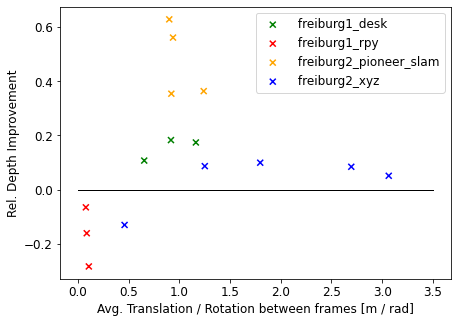

In [11]:
group = df['Sequence'].values
scatter_x = df["Trans over Rot"].values
scatter_y = df["Relative Validation Improvement"].values
colors = df['color'].values
figure6 = plt.figure(figsize=(7,5))
for g in np.unique(group):
    ix = np.where(group == g)
    plt.scatter(scatter_x[ix], scatter_y[ix], c = colors[ix], label = g, marker = 'x')
plt.plot([0, 3.5], [0, 0], c='black', linewidth = 1)
plt.xlabel('Avg. Translation / Rotation between frames [m / rad]')
plt.ylabel('Rel. Depth Improvement')
plt.legend()
figure6.savefig("../presentation/trans_over_rot.pdf", bbox_inches='tight')
figure6.savefig("../presentation/trans_over_rot.png", bbox_inches='tight')

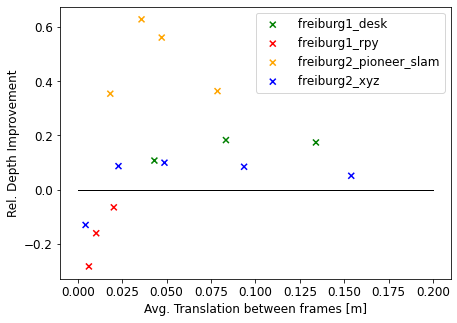

In [12]:
group = df['Sequence'].values
scatter_x = df["Avg. Translation"].values
scatter_y = df["Relative Validation Improvement"].values
colors = df['color'].values
figure7 = plt.figure(figsize=(7,5))
for g in np.unique(group):
    ix = np.where(group == g)
    plt.scatter(scatter_x[ix], scatter_y[ix], c = colors[ix], label = g, marker = 'x')
plt.plot([0, 0.2], [0, 0], c='black', linewidth = 1)
plt.xlabel('Avg. Translation between frames [m]')
plt.ylabel('Rel. Depth Improvement')
plt.legend()
figure7.savefig("../presentation/trans.pdf", bbox_inches='tight')
figure7.savefig("../presentation/trans.png", bbox_inches='tight')